## 1. Import and utilities

In [54]:
import time
import pickle

import numpy as np
import random

%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from utils import *
from q_learning import *
from deep_q_learning import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
# Configurations
save_stats = False
save_figs = False
train = False
load = not train

seed = 0

## 2. Q-Learning

In [56]:
env = TictactoeEnv()

# Hyper-parameters
alpha = 0.05    # Learning rate
gamma = 0.99    # Discount factor
epsilon_opt = 0.5   # Optimal player's epsilon
num_episodes = 20000 # number of episodes
num_avg = 10 # training runs
test_freq = 250 # test frequency
epsilon_min = 0.1 # minimum exploration rate for n^star
epsilon_max = 0.8 # maximum exploration rate for n^star

### 2.1 Learning from experts

#### Question 1: Average reward with $\epsilon = 0.1$

epsilon_exploration_Q1 = 0.1 : 	M_opt =  0.0 	M_rand =  0.838


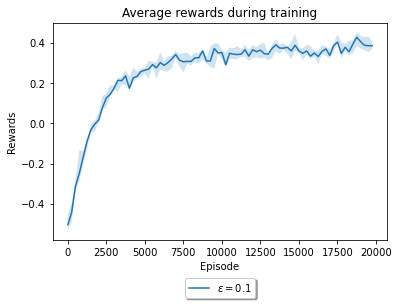

In [57]:
# Seed
np.random.seed(seed)
random.seed(seed)

# Training, we average the results over 10 training runs
epsilon_exploration = 0.1
stats_dict_list = []
if train:
    for i in range(num_avg):
        print('************** RUN', i+1, 'OF', num_avg, '**************')
        stats_dict = {}
        start = time.time()
        Q, stats = q_learning(env, epsilon_exploration=epsilon_exploration, num_episodes=num_episodes, verbose=False, against_opt=True)
        M_opt = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.))
        M_rand = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.))
        print("M_opt =", M_opt)
        print("M_rand =", M_rand)
        stats_dict.update({epsilon_exploration: (stats, M_opt, M_rand)})
        stats_dict_list.append(stats_dict)
        print('RUN', i+1, 'took', np.round(time.time()-start,decimals=1), 'seconds')
    # Saving the results
    if save_stats:
        output_folder = os.path.join(os.getcwd(), 'results')
        os.makedirs(output_folder, exist_ok=True)
        fname = output_folder + '/Q1.pkl'
        with open(fname, 'wb') as handle:
            pickle.dump(stats_dict_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load results from dictionary
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    fname = output_folder + '/Q1.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_list = pickle.load(handle)
        
# Plot of the average reward over num_avg training runs with 25th and 75th percentiles'        
plot_stats(stats_dict_list, [epsilon_exploration], 'epsilon_exploration_Q1', '\epsilon', save=save_figs, keys = ['rewards'], perc=True)

#### Questions 2 and 3: Average reward and performance measures for different values of $n^{\star}$ 

In [ ]:
test_freq = 250
vec_n_star = np.hstack((np.array([1, 100, 500, 750]), np.round(np.logspace(3, np.log10(40000), 16))))

In [ ]:
q_learning_params_list = []
var_name = 'q_learning_n_star_experts'
for n_star in vec_n_star:
    params = {'env': env,
              'epsilon_exploration_rule': return_lambda_explor(epsilon_min, epsilon_max, n_star),
              'test_freq': test_freq, 
              'against_opt': True}
    q_learning_params_list.append(params)

In [ ]:
np.random.seed(seed)
random.seed(seed)

# Training, performs num_avg complete training runs
if train:
    stats_dict_nstar = train_avg(var_name, vec_n_star, q_learning_params_list, num_avg=num_avg, save_stats=save_stats)

# Load results from dictionary
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_q_learning_n_star_experts_list.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_nstar_list = pickle.load(handle)

In [ ]:
# Show plot presented in the report
plot_n_star = [1., 9146., 19127., 40000]
plot_stats(stats_dict_nstar_list, plot_n_star, 'n_star', "n^{\star}", save=save_figs, decaying_exploration=True, perc=True)

In [ ]:
# Show plot of all the experimented values
plot_stats(stats_dict_nstar_list, vec_n_star, 'n_star', "n^{\star}", save=save_figs, decaying_exploration=True, perc=True)

#### Question 4: Good experts and bad experts

In [58]:
best_n_star = 9146 # best value according to previous experiments
M = 11
vec_eps_opt = np.round(np.linspace(0, 1, M), decimals=2)
var_name = 'epsilon_opt'
q_learning_params_list = []
for epsilon_opt in vec_eps_opt:
    params = {'env': env,
              'num_episodes': num_episodes,
              'epsilon_exploration_rule': return_lambda_explor(epsilon_min, epsilon_max, best_n_star),
              'epsilon_opt': epsilon_opt,
              'against_opt': True}
    q_learning_params_list.append(params)

In [59]:
# Seed
np.random.seed(seed)
random.seed(seed)

# Training, performs num_avg complete training runs
if train:
    stats_dict_eps_opt_list = train_avg(var_name, vec_eps_opt, q_learning_params_list, num_avg=num_avg, save_stats=save_stats)
    
# Load results from dictionary
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_epsilon_opt_list.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_eps_opt_list = pickle.load(handle)

epsilon_opt = 0.0 : 	M_opt =  0.0 	M_rand =  0.101
epsilon_opt = 0.2 : 	M_opt =  0.0 	M_rand =  0.612
epsilon_opt = 0.5 : 	M_opt =  0.0 	M_rand =  0.849
epsilon_opt = 0.8 : 	M_opt =  -0.253 	M_rand =  0.874
epsilon_opt = 1.0 : 	M_opt =  -0.348 	M_rand =  0.877


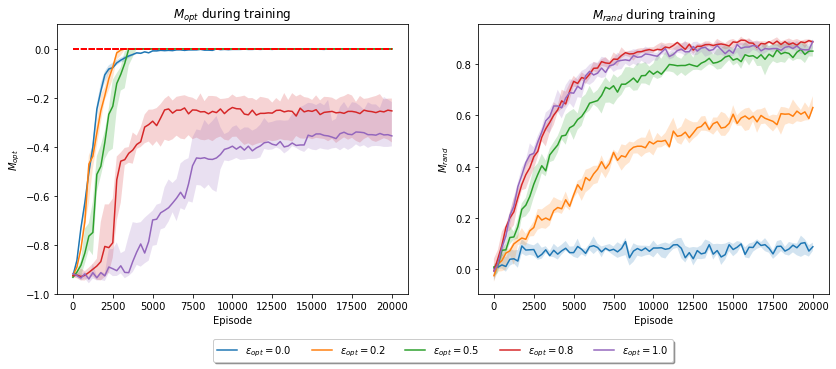

In [60]:
# Show plot presented in the report
plot_eps_opt = [0., 0.2, 0.5, 0.8, 1.]
plot_stats(stats_dict_eps_opt_list, plot_eps_opt, "epsilon_opt", "\epsilon_{opt}", save=save_figs, keys=['test_Mopt', 'test_Mrand'], perc=True)

epsilon_opt = 0.0 : 	M_opt =  0.0 	M_rand =  0.101
epsilon_opt = 0.1 : 	M_opt =  0.0 	M_rand =  0.442
epsilon_opt = 0.2 : 	M_opt =  0.0 	M_rand =  0.612
epsilon_opt = 0.3 : 	M_opt =  0.0 	M_rand =  0.762
epsilon_opt = 0.4 : 	M_opt =  0.0 	M_rand =  0.8
epsilon_opt = 0.5 : 	M_opt =  0.0 	M_rand =  0.849
epsilon_opt = 0.6 : 	M_opt =  0.0 	M_rand =  0.873
epsilon_opt = 0.7 : 	M_opt =  -0.043 	M_rand =  0.892
epsilon_opt = 0.8 : 	M_opt =  -0.253 	M_rand =  0.874
epsilon_opt = 0.9 : 	M_opt =  -0.276 	M_rand =  0.895
epsilon_opt = 1.0 : 	M_opt =  -0.348 	M_rand =  0.877


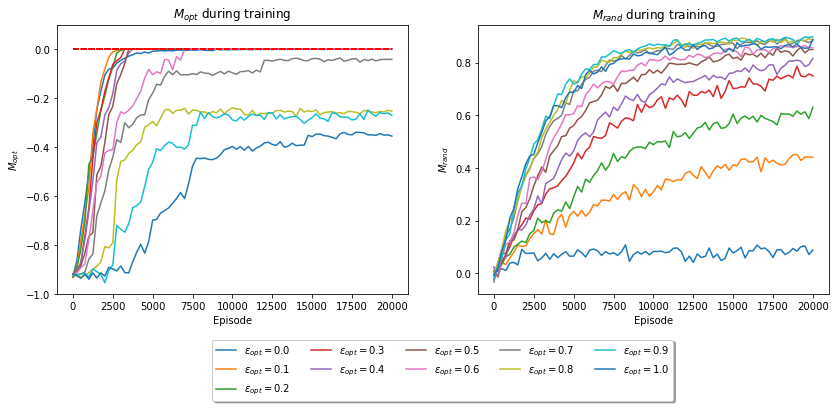

In [61]:
# Show plot of all the experimented values
plot_stats(stats_dict_eps_opt_list, vec_eps_opt, "epsilon_opt", "\epsilon_{opt}", save=False, keys=['test_Mopt', 'test_Mrand'])

#### Question 5: Optimal values of $M_{\text{opt}}$ and $M_{\text{rand}}$

In [62]:
# Seed
np.random.seed(seed)
random.seed(seed)

# Setting hyperparams
n_star = 9146 # best n_star
epsilon_min = 0.1
epsilon_max = 0.8
epsilon_exploration_rule = return_lambda_explor(epsilon_min, epsilon_max, n_star)

# Training and measuring performance, average over 10 complete runs
m_opt_vec = []
m_rand_vec = []
for i in range(10):
    Q, stats = q_learning(env, epsilon_exploration_rule = epsilon_exploration_rule, against_opt=True)
    # Measuring performance
    m_opt = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.))
    m_rand = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.))
    m_opt_vec.append(m_opt)
    m_rand_vec.append(m_rand)
    print("Finished run", i+1, "of", num_avg)

# Results
print('*********************', ' AVERAGE STATS ', '*********************')
print("Median:\tM_opt = ", np.round(np.median(m_opt_vec),decimals=3), "\t M_rand = ", np.round(np.median(m_rand_vec),decimals=3))
print("25th quantile:\tM_opt = ", np.round(np.percentile(m_opt_vec, q=25),decimals=3), "\t M_rand = ", np.round(np.percentile(m_rand_vec, q=25),decimals=3))
print("75th quantile:\tM_opt = ", np.round(np.percentile(m_opt_vec, q=75),decimals=3), "\t M_rand = ", np.round(np.percentile(m_rand_vec, q=75),decimals=3))

Finished run 1 of 10
Finished run 2 of 10
Finished run 3 of 10
Finished run 4 of 10
Finished run 5 of 10
Finished run 6 of 10
Finished run 7 of 10
Finished run 8 of 10
Finished run 9 of 10
Finished run 10 of 10
*********************  AVERAGE STATS  *********************
Median:	M_opt =  0.0 	 M_rand =  0.827
25th quantile:	M_opt =  0.0 	 M_rand =  0.815
75th quantile:	M_opt =  0.0 	 M_rand =  0.848


### 2.2 Learning by self-practice

#### Question 7: performance measures $M_{\text{opt}}$ and $M_{\text{rand}}$ for different exploration rates $\epsilon$

In [63]:
eps_vec = np.round(np.linspace(0, 0.9, 10), decimals=1)
var_name = 'eps_self'
q_learning_params_list = []
for eps in eps_vec:
    params = {'env': env,
              'verbose': True,
              'num_episodes': num_episodes,
              'epsilon_exploration': eps,
              'test_freq': test_freq,
              'self_practice': True}
    q_learning_params_list.append(params)

In [64]:
# Seed
np.random.seed(seed)
random.seed(seed)

# Training, performs num_avg complete training runs
if train:
    stats_dict_eps_self_list = train_avg(var_name, eps_vec, q_learning_params_list, num_avg=num_avg, save_stats=save_stats)

# Load results from dictionary
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_eps_self_list.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_eps_self_list = pickle.load(handle)

epsilon_self = 0 : 	M_opt =  -0.843 	M_rand =  0.18
epsilon_self = 0.2 : 	M_opt =  -0.239 	M_rand =  0.77
epsilon_self = 0.5 : 	M_opt =  -0.113 	M_rand =  0.877
epsilon_self = 0.8 : 	M_opt =  -0.302 	M_rand =  0.898


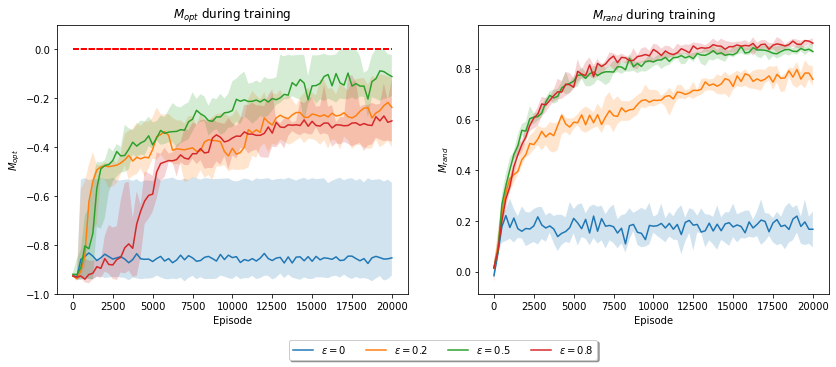

In [65]:
# Show plot presented in the report
eps_vec_plot = [0, 0.2, 0.5, 0.8]
plot_stats(stats_dict_eps_self_list, eps_vec_plot, "epsilon_self", "\epsilon", save=save_figs, perc=True, keys=['test_Mopt', 'test_Mrand'])

epsilon_self = 0.0 : 	M_opt =  -0.843 	M_rand =  0.18
epsilon_self = 0.1 : 	M_opt =  -0.352 	M_rand =  0.655
epsilon_self = 0.2 : 	M_opt =  -0.239 	M_rand =  0.77
epsilon_self = 0.3 : 	M_opt =  -0.158 	M_rand =  0.834
epsilon_self = 0.4 : 	M_opt =  -0.236 	M_rand =  0.862
epsilon_self = 0.5 : 	M_opt =  -0.113 	M_rand =  0.877
epsilon_self = 0.6 : 	M_opt =  -0.20800000000000002 	M_rand =  0.905
epsilon_self = 0.7 : 	M_opt =  -0.131 	M_rand =  0.892
epsilon_self = 0.8 : 	M_opt =  -0.302 	M_rand =  0.898
epsilon_self = 0.9 : 	M_opt =  -0.285 	M_rand =  0.918


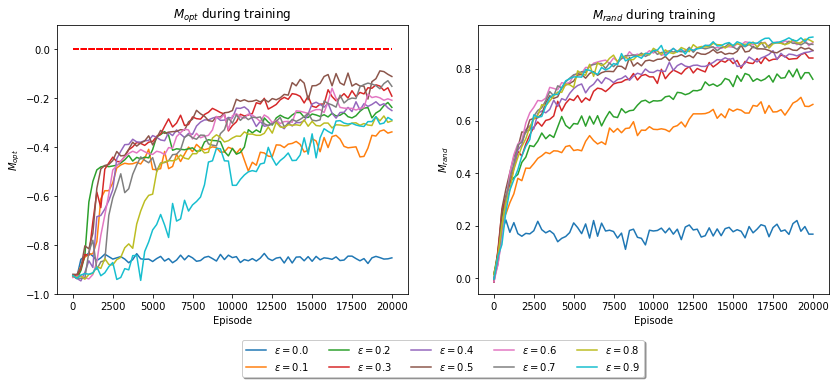

In [66]:
# Show plot of all the experimented values
plot_stats(stats_dict_eps_self_list, eps_vec, "epsilon_self", "\epsilon", save=False, keys=['test_Mopt', 'test_Mrand'])

#### Question 8: Performance measures  $M_{\text{opt}}$ and $M_{\text{rand}}$ for different values of $n^{\star}$

In [67]:
epsilon_min = 0.1
epsilon_max = 0.8
vec_n_star = np.hstack((np.array([1, 100, 500, 750]), np.round(np.logspace(3, np.log10(40000), 16))))

In [68]:
q_learning_params_list = []
var_name = 'q_learning_n_star_self'
for n_star in vec_n_star:
    params = {'env': env,
              'num_episodes': num_episodes,
              'epsilon_exploration_rule': return_lambda_explor(epsilon_min, epsilon_max, n_star),
              'test_freq': test_freq,
              'self_practice': True}
    q_learning_params_list.append(params)

In [69]:
# Seed
np.random.seed(seed)
random.seed(seed)

# Training, performs num_avg complete training runs
if train:
    stats_dict_nstar = train_avg(var_name, vec_n_star, q_learning_params_list, num_avg=num_avg, save_stats=save_stats)

# Load results from dictionary 
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_q_learning_n_star_self_list.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_nstar_list = pickle.load(handle)

n_star_self = 1.0 : 	M_opt =  -0.331 	M_rand =  0.6839999999999999
n_star_self = 9146.0 : 	M_opt =  -0.11 	M_rand =  0.838
n_star_self = 24460.0 : 	M_opt =  -0.07100000000000001 	M_rand =  0.871
n_star_self = 40000.0 : 	M_opt =  -0.118 	M_rand =  0.914


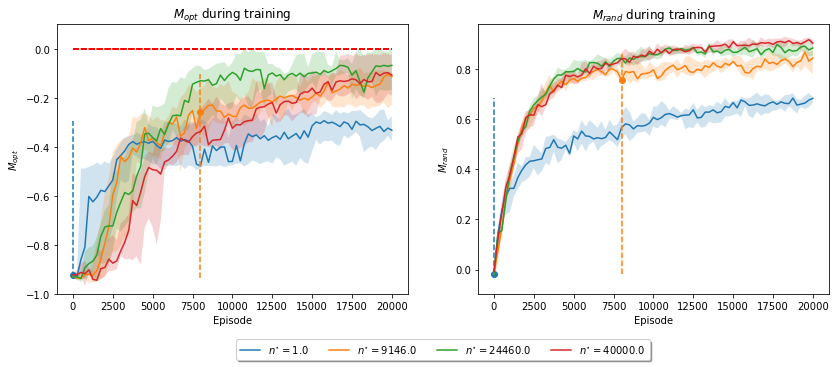

In [70]:
# Show plot presented in the report
plot_n_star = [1., 9146., 24460., 40000.]
plot_stats(stats_dict_nstar_list, plot_n_star, 'n_star_self', "n^{\star}", 
           decaying_exploration=True, save=save_figs, perc=True, keys=['test_Mopt', 'test_Mrand'])

n_star_self = 1.0 : 	M_opt =  -0.331 	M_rand =  0.6839999999999999
n_star_self = 100.0 : 	M_opt =  -0.313 	M_rand =  0.668
n_star_self = 500.0 : 	M_opt =  -0.28500000000000003 	M_rand =  0.649
n_star_self = 750.0 : 	M_opt =  -0.355 	M_rand =  0.644
n_star_self = 1000.0 : 	M_opt =  -0.257 	M_rand =  0.688
n_star_self = 1279.0 : 	M_opt =  -0.258 	M_rand =  0.705
n_star_self = 1635.0 : 	M_opt =  -0.275 	M_rand =  0.692
n_star_self = 2091.0 : 	M_opt =  -0.29 	M_rand =  0.685
n_star_self = 2674.0 : 	M_opt =  -0.29600000000000004 	M_rand =  0.702
n_star_self = 3420.0 : 	M_opt =  -0.32 	M_rand =  0.709
n_star_self = 4373.0 : 	M_opt =  -0.279 	M_rand =  0.74
n_star_self = 5593.0 : 	M_opt =  -0.239 	M_rand =  0.753
n_star_self = 7152.0 : 	M_opt =  -0.183 	M_rand =  0.806
n_star_self = 9146.0 : 	M_opt =  -0.11 	M_rand =  0.838
n_star_self = 11696.0 : 	M_opt =  -0.16599999999999998 	M_rand =  0.811
n_star_self = 14957.0 : 	M_opt =  -0.14 	M_rand =  0.843
n_star_self = 19127.0 : 	M_opt =  -0.201 	

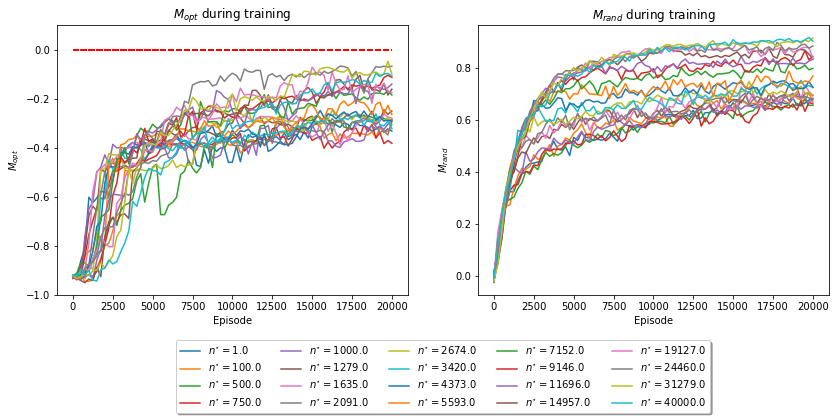

In [71]:
# Show plot of all the experimented values
plot_stats(stats_dict_nstar_list, vec_n_star, 'n_star_self', "n^{\star}", save=False, keys=['test_Mopt', 'test_Mrand'])

#### Question 9: Optimal values of $M_{\text{opt}}$ and $M_{\text{rand}}$

In [72]:
# Seed
np.random.seed(seed)
random.seed(seed)

# Setting hyperparams
n_star = 24460
epsilon_exploration_rule = return_lambda_explor(epsilon_min, epsilon_max, n_star)

# Training, average over 10 complete runs
m_opt_vec = []
m_rand_vec = []
for i in range(10):
    Q, stats = q_learning(env, epsilon_exploration_rule = epsilon_exploration_rule, self_practice=True)
    # Measuring performance
    m_opt = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.))
    m_rand = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.))
    m_opt_vec.append(m_opt)
    m_rand_vec.append(m_rand)
    print("Finished run", i+1, "of", num_avg)

# Results
print('*********************', ' AVERAGE STATS ', '*********************')
print("Median:\tM_opt = ", np.round(np.median(m_opt_vec),decimals=3), "\t M_rand = ", np.round(np.median(m_rand_vec),decimals=3))
print("25th quantile:\tM_opt = ", np.round(np.percentile(m_opt_vec, q=25),decimals=3), "\t M_rand = ", np.round(np.percentile(m_rand_vec, q=25),decimals=3))
print("75th quantile:\tM_opt = ", np.round(np.percentile(m_opt_vec, q=75),decimals=3), "\t M_rand = ", np.round(np.percentile(m_rand_vec, q=75),decimals=3))

Finished run 1 of 10
Finished run 2 of 10
Finished run 3 of 10
Finished run 4 of 10
Finished run 5 of 10
Finished run 6 of 10
Finished run 7 of 10
Finished run 8 of 10
Finished run 9 of 10
Finished run 10 of 10
*********************  AVERAGE STATS  *********************
Median:	M_opt =  -0.071 	 M_rand =  0.874
25th quantile:	M_opt =  -0.252 	 M_rand =  0.846
75th quantile:	M_opt =  0.0 	 M_rand =  0.889


#### Question 10: Heatmaps of the Q-values in 3 significant states

In [73]:
# Seed
np.random.seed(seed)
random.seed(seed)

# Optimal params
epsilon_min = 0.1
epsilon_max = 0.8
n_star = 24460
epsilon_exploration_rule = return_lambda_explor(epsilon_min, epsilon_max, n_star)

# Training
Q, stats = q_learning(env, alpha=0.05, epsilon_exploration_rule=epsilon_exploration_rule, self_practice=True)

C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 5 rows containing missing values.
C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 4 rows containing missing values.


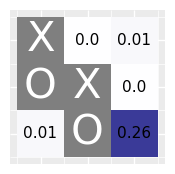

C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 6 rows containing missing values.
C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 3 rows containing missing values.


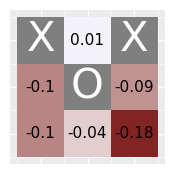

C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 5 rows containing missing values.
C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 4 rows containing missing values.


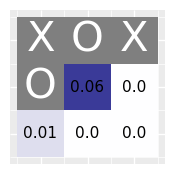

In [74]:
# States of interest
win_chance = [1., 0., 0., -1., 1., 0., 0., -1., 0.]
block_win = [1., 0., 1., 0., -1., 0., 0., 0., 0.]
fork_chance = [1., -1., 1., -1., 0., 0., 0., 0., 0.]
grids = [win_chance, block_win, fork_chance]
# Converting to numpy
grid_numpy = []
for i in range(len(grids)):
    grid_numpy.append(np.array(grids[i]).reshape(3,3))
    
# Plot heatmaps
heatmaps_subplots(grid_numpy, Q, save=save_figs)

## 3. Deep Q-Learning

In [75]:
# Configuration paramaters for the whole setup
env = TictactoeEnv()

lr = 1e-4 # learning rate obtained by grid search
num_episodes = 20000
test_freq = 250
num_avg = 4
epsilon_min = 0.1
epsilon_max = 0.8

# Folder for results
output_folder = os.path.join(os.getcwd(), 'results')
os.makedirs(output_folder, exist_ok=True)

### 3.1 Learning from experts

#### Question 11: Average reward and average loss during training for $\epsilon = 0.1$

epsilon_exploration_Q11 = 0.1 : 	M_opt =  0.0 	M_rand =  0.954


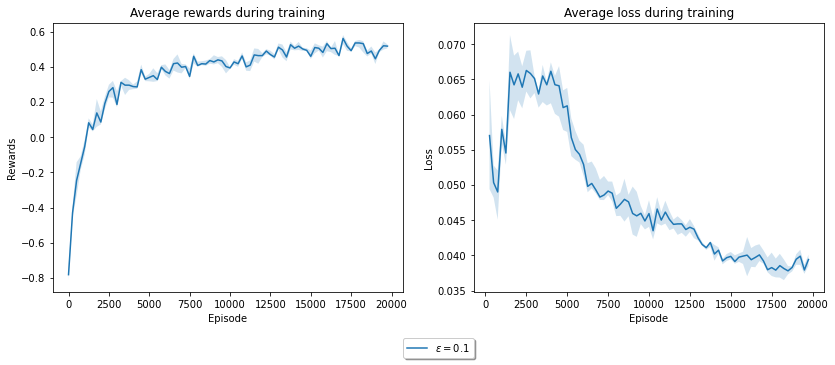

In [76]:
# Seed
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# Training, performs num_avg complete training runs without performance test
epsilon_exploration = 0.1
stats_dict_list = []
if train:
    for i in range(num_avg):
        print('************** RUN', i+1, 'OF', num_avg, '**************')
        stats_dict = {}
        start = time.time()
        model, stats = deep_q_learning(env, lr = lr, epsilon_exploration=epsilon_exploration, num_episodes=num_episodes, against_opt=True, verbose=True)
        print('Only training time: ', time.time() - start)
        M_opt = measure_performance(DeepQPlayer(model=model), OptimalPlayer(epsilon=0.))
        M_rand = measure_performance(DeepQPlayer(model=model), OptimalPlayer(epsilon=1.))
        print("M_opt =", M_opt)
        print("M_rand =", M_rand)
        stats_dict.update({epsilon_exploration: (stats, M_opt, M_rand)})
        stats_dict_list.append(stats_dict)
        print('RUN', i+1, 'took', np.round(time.time()-start,decimals=1), 'seconds')
    if save_stats:
        fname = output_folder + '/dqn_stats_dict_q11.pkl'
        with open(fname, 'wb') as handle:
            pickle.dump(stats_dict_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load results from dictionary
if load:
    fname = output_folder + '/dqn_stats_dict_q11.pkl'
    with open(fname, 'rb') as handle:
            stats_dict_list = pickle.load(handle)

# Plot of the average reward and average training loss over num_avg training runs with 25th and 75th percentiles'   
plot_stats(stats_dict_list, [epsilon_exploration], 'epsilon_exploration_Q11', '\epsilon', save=save_figs, keys = ['rewards', 'loss'], perc=True)

#### Question 12: Same as Question 11, but no replay buffer and batch_size = 1

epsilon_exploration_Q12 = 0.1 : 	M_opt =  -0.08399999999999999 	M_rand =  0.861


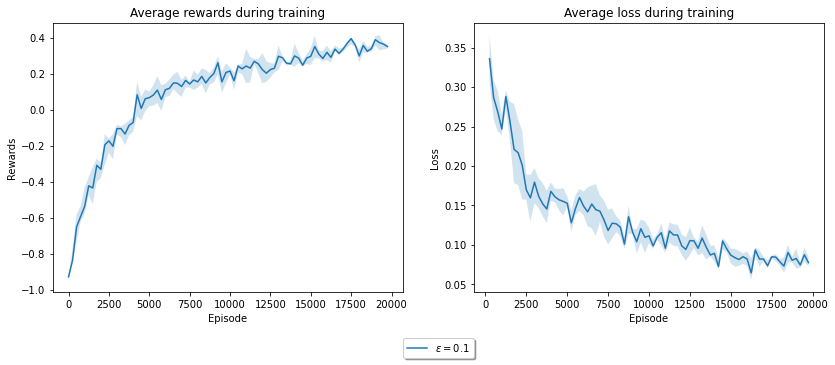

In [77]:
# Seed
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# Training, performs num_avg complete training runs without performance test
epsilon_exploration = 0.1
stats_dict_list = []
if train:
    for i in range(num_avg):
        print('************** RUN', i+1, 'OF', num_avg, '**************')
        stats_dict = {}
        start = time.time()
        model, stats = deep_q_learning(env, epsilon_exploration=epsilon_exploration, num_episodes=num_episodes, against_opt=True, batch_size=1, max_memory_length=1)
        M_opt = measure_performance(DeepQPlayer(model=model), OptimalPlayer(epsilon=0.))
        M_rand = measure_performance(DeepQPlayer(model=model), OptimalPlayer(epsilon=1.))
        print("M_opt =", M_opt)
        print("M_rand =", M_rand)
        stats_dict.update({epsilon_exploration: (stats, M_opt, M_rand)})
        stats_dict_list.append(stats_dict)
        print('RUN', i+1, 'took', np.round(time.time()-start,decimals=1), 'seconds')
    if save_stats:
        fname = output_folder + '/dqn_stats_dict_q12.pkl'
        with open(fname, 'wb') as handle:
            pickle.dump(stats_dict_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load results from dictionary
if load:
    fname = output_folder + '/dqn_stats_dict_q12.pkl'
    with open(fname, 'rb') as handle:
            stats_dict_list = pickle.load(handle)

# Plot of the average reward and average training loss over num_avg training runs with 25th and 75th percentiles'              
plot_stats(stats_dict_list, [epsilon_exploration], 'epsilon_exploration_Q12', '\epsilon', save=save_figs, keys = ['rewards', 'loss'], perc=True)

#### Question 13: Performance measures $M_{\text{opt}}$ and $M_{\text{rand}}$ for different values of $n^{*}$

In [78]:
vec_n_star = np.hstack((np.array([1, 100, 1000]), np.round(np.logspace(np.log10(5000), np.log10(40000), 7))))
var_name = 'deep_q_learning_n_star_experts'
dqn_params_list = []
for n_star in vec_n_star:
    params = {'env': env,
              'num_episodes': num_episodes,
              'epsilon_exploration_rule': return_lambda_explor(epsilon_min, epsilon_max, n_star),
              'test_freq': test_freq,
              'against_opt': True}
    dqn_params_list.append(params)

In [79]:
# Seed
np.random.seed(seed)
random.seed(seed)

# Training, performs num_avg complete training runs
if train:
    stats_dict_nstar = deep_train_avg(var_name, vec_n_star, dqn_params_list, num_avg=num_avg, save_stats=save_stats)

# Load results from dictionary
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/dqn_stats_dict_nstar_experts_list.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_nstar_list = pickle.load(handle)

dqn_n_star = 1.0 : 	M_opt =  0.0 	M_rand =  0.9339999999999999
dqn_n_star = 10000.0 : 	M_opt =  0.0 	M_rand =  0.952
dqn_n_star = 20000.0 : 	M_opt =  0.0 	M_rand =  0.9339999999999999
dqn_n_star = 40000.0 : 	M_opt =  0.0 	M_rand =  0.945


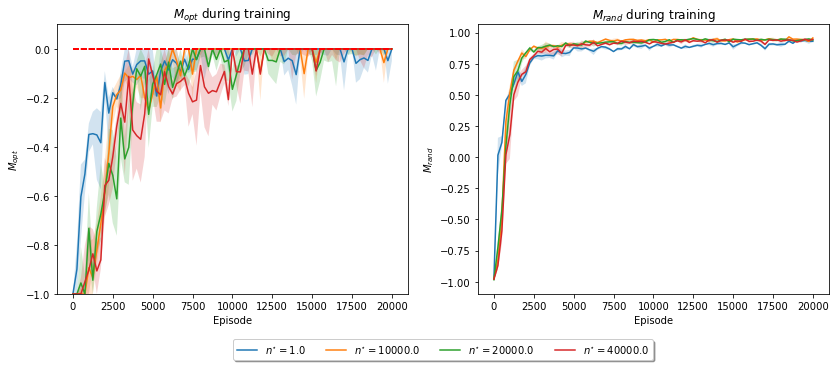

In [80]:
# Show plot presented in the report
plot_n_star = [1., 10000., 20000., 40000.]
plot_stats(stats_dict_nstar_list, plot_n_star, 'dqn_n_star', "n^{\star}", save=save_figs, perc=True, keys=['test_Mopt', 'test_Mrand'])

dqn_n_star = 1.0 : 	M_opt =  0.0 	M_rand =  0.9339999999999999
dqn_n_star = 100.0 : 	M_opt =  0.0 	M_rand =  0.929
dqn_n_star = 1000.0 : 	M_opt =  0.0 	M_rand =  0.942
dqn_n_star = 5000.0 : 	M_opt =  0.0 	M_rand =  0.9410000000000001
dqn_n_star = 7071.0 : 	M_opt =  0.0 	M_rand =  0.938
dqn_n_star = 10000.0 : 	M_opt =  0.0 	M_rand =  0.952
dqn_n_star = 14142.0 : 	M_opt =  -0.096 	M_rand =  0.948
dqn_n_star = 20000.0 : 	M_opt =  0.0 	M_rand =  0.9339999999999999
dqn_n_star = 28284.0 : 	M_opt =  0.0 	M_rand =  0.955
dqn_n_star = 40000.0 : 	M_opt =  0.0 	M_rand =  0.945


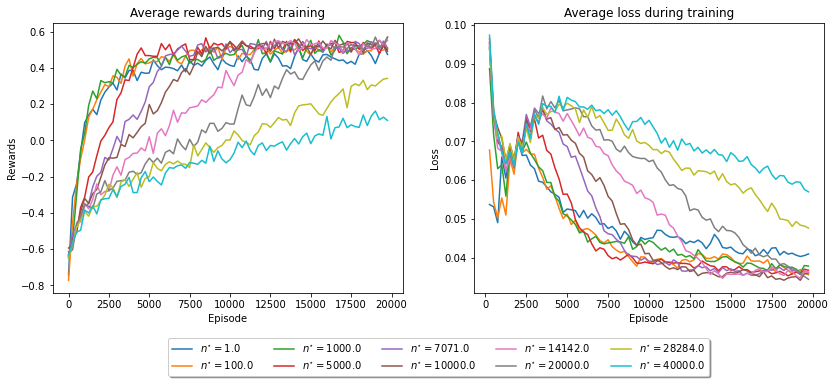

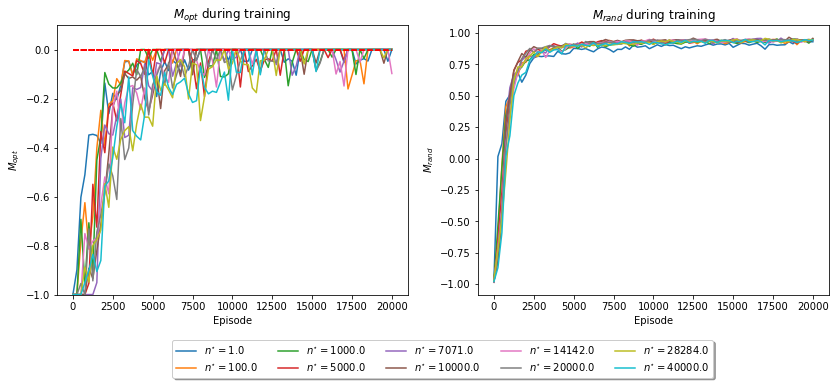

In [81]:
# Show plot of all the experimented values
plot_stats(stats_dict_nstar_list, vec_n_star, 'dqn_n_star', "n^{\star}", save=False, decaying_exploration=False)

#### Question 14: Performance measures  $M_{\text{opt}}$ and $M_{\text{rand}}$ for different values of $\epsilon_{\text{opt}}$

In [82]:
best_n_star = 20000 # best n_star according to the previous experiments
M = 11
vec_eps_opt = np.round(np.linspace(0, 1, M), decimals=2)
deep_q_learning_params_list = []
var_name = 'deep_q_learning_epsilon_opt_experts'
for eps in vec_eps_opt:
    params = {'env': env,
              'num_episodes': num_episodes,
              'epsilon_exploration_rule': return_lambda_explor(epsilon_min, epsilon_max, best_n_star),
              'epsilon_opt': eps,
              'test_freq': test_freq,
              'against_opt': True}
    deep_q_learning_params_list.append(params)

In [83]:
# Seed
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# Training, performs num_avg complete training runs
if train:
    stats_dict_epsilon_opt_list_deep = deep_train_avg(var_name, vec_eps_opt, deep_q_learning_params_list, 
                                                      num_avg=num_avg, save_stats=save_stats)

# Load results from dictionary
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_dqn_epsilon_opt_experts_list.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_eps_opt_list = pickle.load(handle)

dqn_epsilon_opt_experts = 0.0 : 	M_opt =  0.0 	M_rand =  -0.326
dqn_epsilon_opt_experts = 0.2 : 	M_opt =  0.0 	M_rand =  0.92
dqn_epsilon_opt_experts = 0.5 : 	M_opt =  0.0 	M_rand =  0.9390000000000001
dqn_epsilon_opt_experts = 0.7 : 	M_opt =  -0.098 	M_rand =  0.951
dqn_epsilon_opt_experts = 1.0 : 	M_opt =  -0.227 	M_rand =  0.915


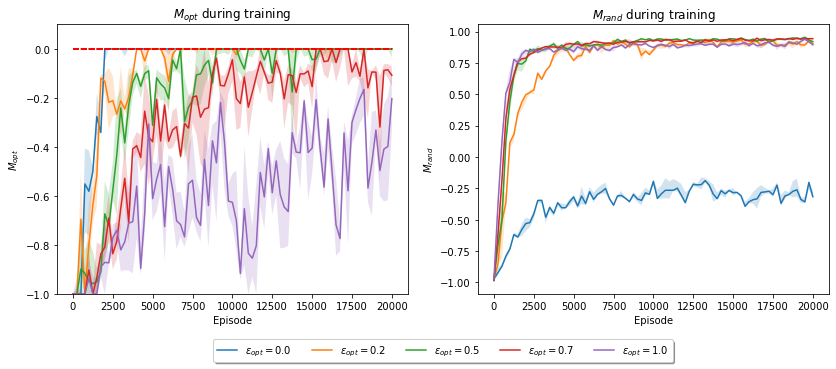

In [84]:
# Show plot presented in the report
plot_epsilon_opt = [0.0, 0.2, 0.5, 0.7, 1.0]
plot_stats(stats_dict_eps_opt_list, plot_epsilon_opt, 'dqn_epsilon_opt_experts', "\epsilon_{opt}", save=save_figs, keys=['test_Mopt', 'test_Mrand'], perc=True)

dqn_epsilon_opt_experts = 0.0 : 	M_opt =  0.0 	M_rand =  -0.326
dqn_epsilon_opt_experts = 0.1 : 	M_opt =  0.0 	M_rand =  0.91
dqn_epsilon_opt_experts = 0.2 : 	M_opt =  0.0 	M_rand =  0.92
dqn_epsilon_opt_experts = 0.3 : 	M_opt =  0.0 	M_rand =  0.9299999999999999
dqn_epsilon_opt_experts = 0.4 : 	M_opt =  0.0 	M_rand =  0.951
dqn_epsilon_opt_experts = 0.5 : 	M_opt =  0.0 	M_rand =  0.9390000000000001
dqn_epsilon_opt_experts = 0.6 : 	M_opt =  0.0 	M_rand =  0.938
dqn_epsilon_opt_experts = 0.7 : 	M_opt =  -0.098 	M_rand =  0.951
dqn_epsilon_opt_experts = 0.8 : 	M_opt =  -0.17300000000000001 	M_rand =  0.937
dqn_epsilon_opt_experts = 0.9 : 	M_opt =  -0.10300000000000001 	M_rand =  0.927
dqn_epsilon_opt_experts = 1.0 : 	M_opt =  -0.227 	M_rand =  0.915


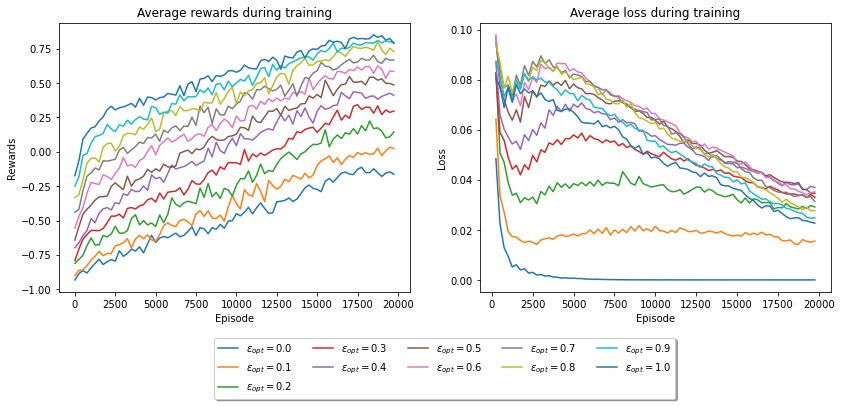

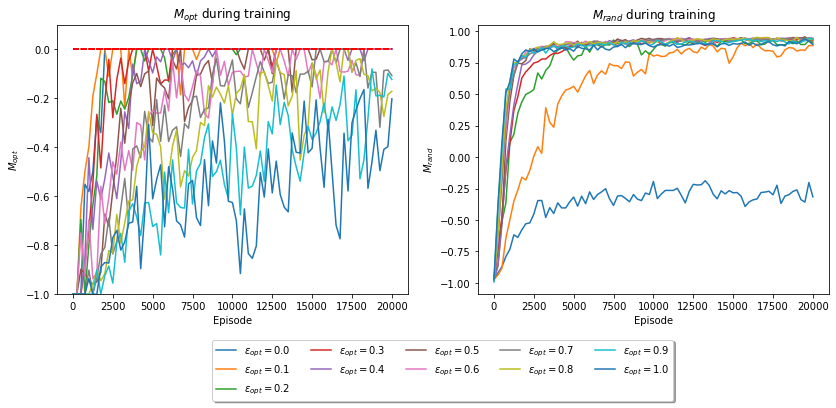

In [85]:
# Show plot of all the experimented values
plot_stats(stats_dict_eps_opt_list, vec_eps_opt, 'dqn_epsilon_opt_experts', "\epsilon_{opt}", save=False)

#### Question 15: Optimal values of $M_{\text{opt}}$ and $M_{\text{rand}}$

In [86]:
# Seed
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
# Optimal params
epsilon_min = 0.1
epsilon_max = 0.8
n_star = 20000
epsilon_exploration_rule = return_lambda_explor(epsilon_min, epsilon_max, n_star)

# Training, single run
model, stats = deep_q_learning(env, epsilon_exploration_rule=epsilon_exploration_rule, against_opt=True)

# Print results
M_opt = measure_performance(DeepQPlayer(model=model), OptimalPlayer(epsilon=0.))
print("M_opt =", M_opt)
M_rand = measure_performance(DeepQPlayer(model=model), OptimalPlayer(epsilon=1.))
print("M_rand =", M_rand)

100%|██████████| 20000/20000 [12:46<00:00, 26.11it/s]


M_opt = 0.0
M_rand = 0.952


## 3.2 Learning by self-practice

#### Question 16: Performance measures $M_{\text{opt}}$ and $M_{\text{rand}}$ for different exploration rates $\epsilon$

In [87]:
M = 10
vec_eps = np.linspace(0, 0.9, M)
var_name = 'deep_q_learning_epsilon_self'
dqn_params_list = []
for eps in vec_eps:
    params = {'env': env,
          'num_episodes': num_episodes,
          'epsilon_exploration': eps,
          'verbose': True,
          'test_freq': test_freq,
          'self_practice': True}
    dqn_params_list.append(params)

In [88]:
# Seed
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# Training, performs num_avg complete training runs
if train:
    stats_dict_epsilon_self_list_deep = deep_train_avg(var_name, vec_eps, dqn_params_list, num_avg=num_avg, save_stats=save_stats)

# Load results from dictionary
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_dqn_eps_self_practice.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_epsilon_self_list_deep = pickle.load(handle)

epsilon_dqn_self = 0 : 	M_opt =  -1.0 	M_rand =  0.14
epsilon_dqn_self = 0.2 : 	M_opt =  0.0 	M_rand =  0.935
epsilon_dqn_self = 0.5 : 	M_opt =  0.0 	M_rand =  0.93
epsilon_dqn_self = 0.8 : 	M_opt =  -0.45099999999999996 	M_rand =  0.922


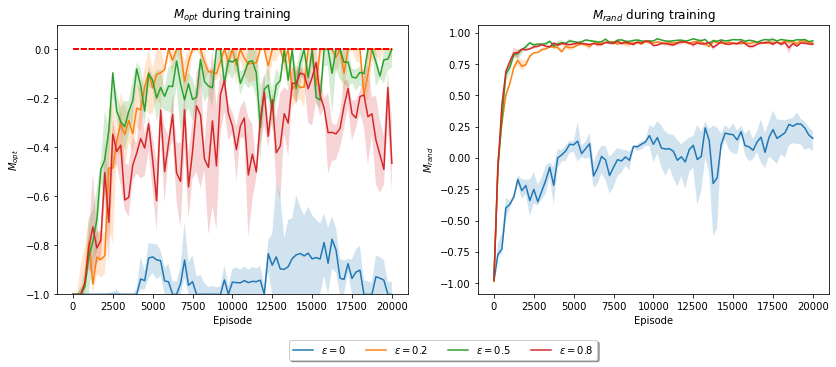

In [89]:
# Show plot presented in the report
plot_eps = [0, 0.2, 0.5, 0.8]
plot_stats(stats_dict_epsilon_self_list_deep, plot_eps, 'epsilon_dqn_self', "\epsilon", save=save_figs, perc=True, keys=['test_Mopt', 'test_Mrand'])

epsilon = 0.0 : 	M_opt =  -1.0 	M_rand =  0.14
epsilon = 0.1 : 	M_opt =  -0.14900000000000002 	M_rand =  0.914
epsilon = 0.2 : 	M_opt =  0.0 	M_rand =  0.935
epsilon = 0.30000000000000004 : 	M_opt =  0.0 	M_rand =  0.936
epsilon = 0.4 : 	M_opt =  -0.053 	M_rand =  0.9390000000000001
epsilon = 0.5 : 	M_opt =  0.0 	M_rand =  0.93
epsilon = 0.6000000000000001 : 	M_opt =  -0.049 	M_rand =  0.921
epsilon = 0.7000000000000001 : 	M_opt =  -0.053 	M_rand =  0.928
epsilon = 0.8 : 	M_opt =  -0.45099999999999996 	M_rand =  0.922
epsilon = 0.9 : 	M_opt =  -0.567 	M_rand =  0.865


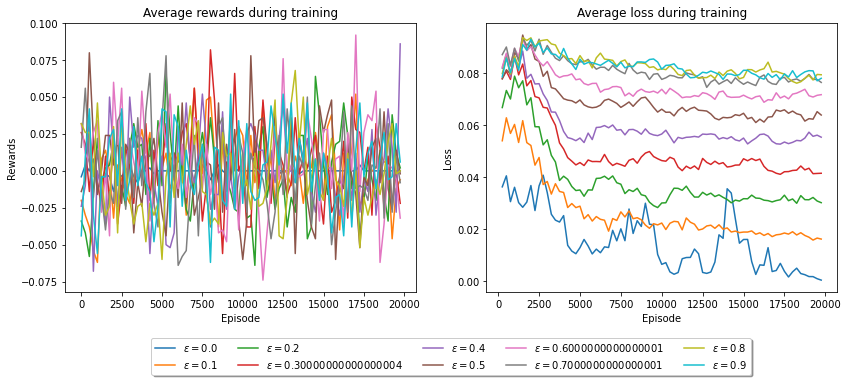

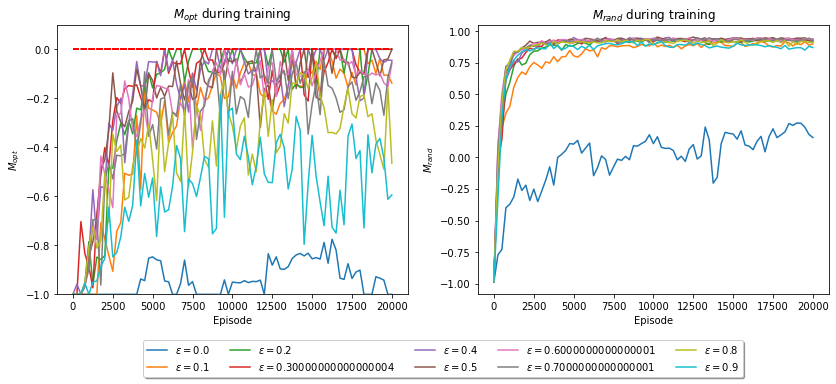

In [90]:
# Show plot of all the experimented values
plot_stats(stats_dict_epsilon_self_list_deep, vec_eps, 'epsilon', "\epsilon", save=False)

#### Question 17: Performance measures $M_{\text{opt}}$ and $M_{\text{rand}}$ for different values of $n^{\star}$

In [91]:
vec_n_star = np.hstack((np.array([1, 100, 1000]), np.round(np.logspace(np.log10(5000), np.log10(40000), 7))))
var_name = 'deep_q_learning_n_star_self'
for n_star in vec_n_star:
    params = {'env': env,
          'num_episodes': num_episodes,
          'epsilon_exploration_rule': return_lambda_explor(epsilon_min, epsilon_max, n_star),
          'verbose': True,
          'test_freq': test_freq,
          'self_practice': True,
              }
    dqn_params_list.append(params)

In [92]:
# Seed
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# Training, performs num_avg complete training runs
if train:
    stats_dict_nstar_self_list_deep = deep_train_avg(var_name, vec_n_star, dqn_params_list,  num_avg=num_avg, save_stats=save_stats)

# Load results from dictionary
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_dqn_n_star_self_practice.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_nstar_self_list_deep = pickle.load(handle)

n_star_dqn_self = 1.0 : 	M_opt =  0.0 	M_rand =  0.908
n_star_dqn_self = 10000.0 : 	M_opt =  0.0 	M_rand =  0.907
n_star_dqn_self = 20000.0 : 	M_opt =  0.0 	M_rand =  0.92
n_star_dqn_self = 40000.0 : 	M_opt =  0.0 	M_rand =  0.9430000000000001


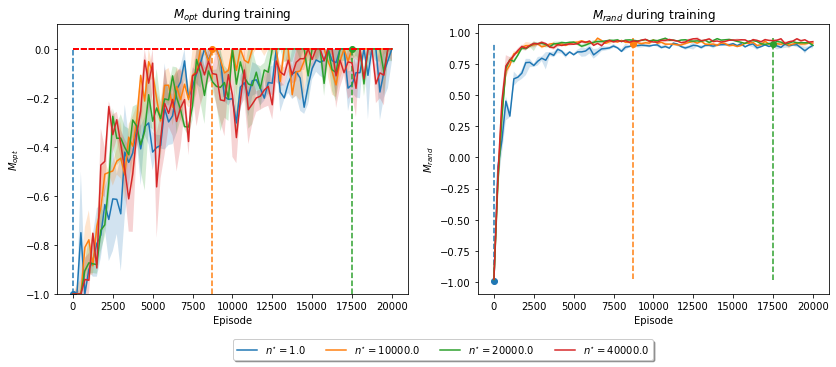

In [93]:
# Show plot presented in the report
plot_n_star = [1., 10000., 20000., 40000.]
plot_stats(stats_dict_nstar_self_list_deep, plot_n_star, 'n_star_dqn_self', "n^{\star}", save=save_figs, decaying_exploration=True, perc=True, keys=['test_Mopt', 'test_Mrand'])

n_star = 1.0 : 	M_opt =  0.0 	M_rand =  0.908
n_star = 100.0 : 	M_opt =  -0.093 	M_rand =  0.867
n_star = 1000.0 : 	M_opt =  0.0 	M_rand =  0.897
n_star = 5000.0 : 	M_opt =  0.0 	M_rand =  0.912
n_star = 7071.0 : 	M_opt =  0.0 	M_rand =  0.915
n_star = 10000.0 : 	M_opt =  0.0 	M_rand =  0.907
n_star = 14142.0 : 	M_opt =  -0.111 	M_rand =  0.914
n_star = 20000.0 : 	M_opt =  0.0 	M_rand =  0.92
n_star = 28284.0 : 	M_opt =  -0.087 	M_rand =  0.928
n_star = 40000.0 : 	M_opt =  0.0 	M_rand =  0.9430000000000001


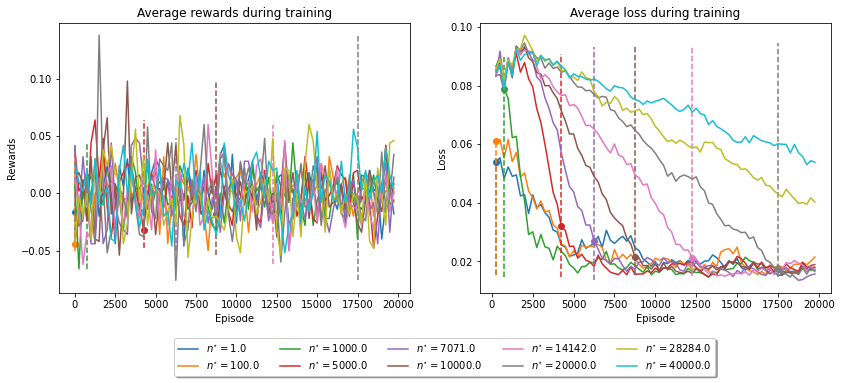

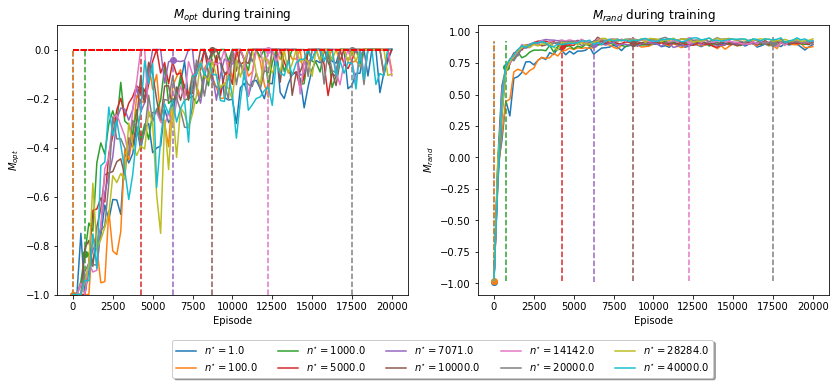

In [94]:
# Show plot of all the experimented values
plot_stats(stats_dict_nstar_self_list_deep, vec_n_star, 'n_star', "n^{\star}", save=False, decaying_exploration=True)

#### Question 18: Optimal values of $M_{\text{opt}}$ and $M_{\text{rand}}$

In [95]:
# Seed
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
# Parameters
epsilon_min = 0.1
epsilon_max = 0.8
n_star = 10000
epsilon_exploration_rule = return_lambda_explor(epsilon_min, epsilon_max, n_star)
# Training, single run
model, stats = deep_q_learning(env, epsilon_exploration_rule=epsilon_exploration_rule, self_practice=True)

# Print results
M_opt = measure_performance(DeepQPlayer(model=model), OptimalPlayer(epsilon=0.))
print("M_opt =", M_opt)
M_rand = measure_performance(DeepQPlayer(model=model), OptimalPlayer(epsilon=1.))
print("M_rand =", M_rand)

100%|██████████| 20000/20000 [23:31<00:00, 14.17it/s]


M_opt = 0.0
M_rand = 0.904


#### Question 19: Heatmaps of the Q-values in 3 significant states

C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 5 rows containing missing values.
C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 4 rows containing missing values.


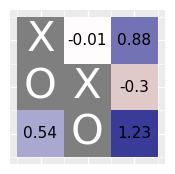

C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 6 rows containing missing values.
C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 3 rows containing missing values.


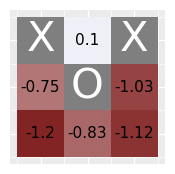

C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 5 rows containing missing values.


C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 4 rows containing missing values.


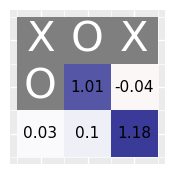

C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 5 rows containing missing values.
C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 4 rows containing missing values.


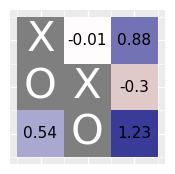

C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 6 rows containing missing values.
C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 3 rows containing missing values.


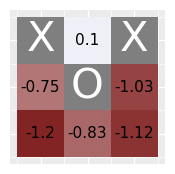

C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 5 rows containing missing values.


C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 4 rows containing missing values.


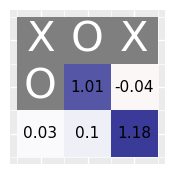

C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 5 rows containing missing values.
C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 4 rows containing missing values.


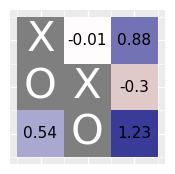

C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 6 rows containing missing values.
C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 3 rows containing missing values.


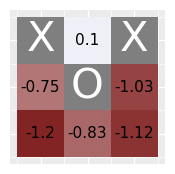

C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 5 rows containing missing values.
C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 4 rows containing missing values.


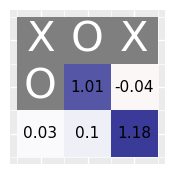

C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 5 rows containing missing values.
C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 4 rows containing missing values.


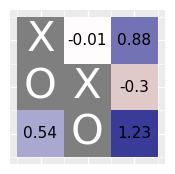

C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 6 rows containing missing values.
C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 3 rows containing missing values.


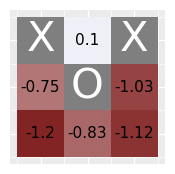

C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 5 rows containing missing values.


C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 4 rows containing missing values.


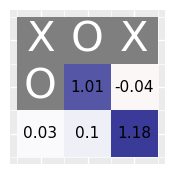

In [99]:
# States of interest
win_chance = [1., 0., 0., -1., 1., 0., 0., -1., 0.]
block_win = [1., 0., 1., 0., -1., 0., 0., 0., 0.]
fork_chance = [1., -1., 1., -1., 0., 0., 0., 0., 0.]
grids = [win_chance, block_win, fork_chance]
grids_numpy = []
# Converting to numpy arrays
for i in range(len(grids)):
    grid_numpy.append(np.array(grids[i]).reshape(3,3))
# Heatmaps
heatmaps_deep_subplots(grid_numpy, model, save=save_figs)

## 4. Comparison between Q-Learning and Deep Q-Learning

#### Question 20: Training times for both learning methods

In [97]:
# TODO